# Exemple sur le modèle jouet Campbell

In [79]:
import numpy as np
import matplotlib.pyplot as plt


In [80]:
%reload_ext autoreload
%autoreload 2
import kernels
import methods

In [81]:
def Simulateur(x,z1,z2):
  return x[0]*np.exp(-(0.8*z1+0.2*z2-10*x[1])**2/(60*x[0]**2))+(x[1]+x[3])*np.exp((0.5*z1+0.5*z2)*x[0]/500)+x[4]*(x[2]-2)*np.exp(-(0.4*z1+0.6*z2-20*x[5])**2/(40*x[4]**2))+(x[5]+x[7])*np.exp((0.3*z1+0.7*z2)*x[6]/250)

#x=np.array([-1,-1,-1,-1,-1,-1,-1,-1])
#x=np.array([5,5,5,5,5,5,5,5])
x=np.array([5,3,1,-1,5,3,1,-1])

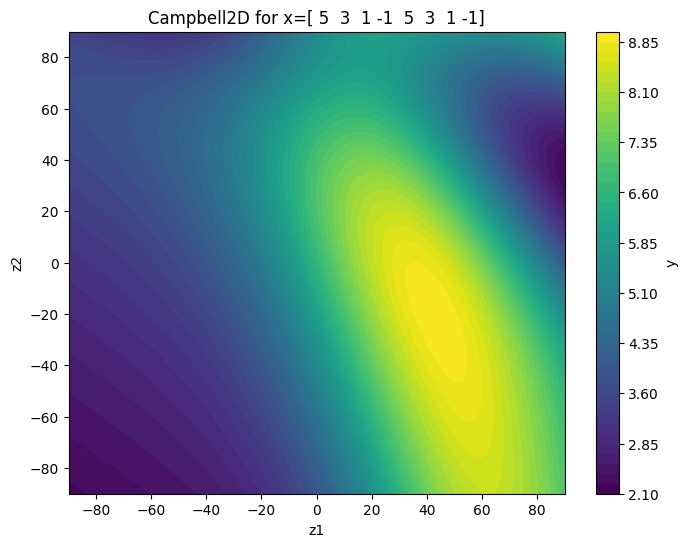

In [82]:
n_grid = 64
D = n_grid**2
z1_vals=np.linspace(-90,90,n_grid)
z2_vals=np.linspace(-90,90,n_grid)

Z1,Z2=np.meshgrid(z1_vals,z2_vals)

Y = Simulateur(x, Z1, Z2)
plt.figure(figsize=(8, 6))
contour = plt.contourf(Z1, Z2, Y, levels=50)
plt.colorbar(contour, label='y')
plt.xlabel('z1')
plt.ylabel('z2')
plt.title(f'Campbell2D for x={x}')
plt.show()

In [83]:
n_test=1000
n_train = 200
n_dim = 8
bounds = np.array([-np.ones(n_dim),5*np.ones(n_dim)])
x_train = methods.lhs_optimized(n_train, n_dim ,bounds, n_iter=500, seed=42)#on simule les données d'entrée avec LHS et SA
x_test=np.random.uniform(-1,5,(n_test,n_dim)) #On simule les données de test avec une loi uniforme
y_train = np.zeros((n_train,n_grid*n_grid))  # matrice (1000, 4096)
y_test = np.zeros((n_test,n_grid*n_grid))
for i in range(n_train):
    ytrain_i = Simulateur(x_train[i], Z1, Z2)
    y_train[i,:] = ytrain_i.flatten()

for i in range(n_test):
    ytest_i = Simulateur(x_test[i], Z1, Z2)
    y_test[i,:] = ytest_i.flatten()
print("Forme de y :",y_train.shape)

Forme de y : (200, 4096)


## Méthode par ACP

In [84]:
#La fonction est dans le fichier methods.py
n_pc = 5 #nombre composantes principales
param = [3,1] #theta,sigma
Y_test_reconstruct = methods.ACP(x_train,x_test,y_train,n_pc,param)

(200, 5)
Variance expliquée par les 5 premières composantes : [0.77542983 0.13512075 0.03266067 0.0195173  0.01679901]
Variance globale expliquée : 0.9795275725785995
Taille du jeu d'entrainement transformé par ACP : (200, 5)


c:\Users\sliss\anaconda3\envs\PIR\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\sliss\anaconda3\envs\PIR\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Affichage des résultats en 2D

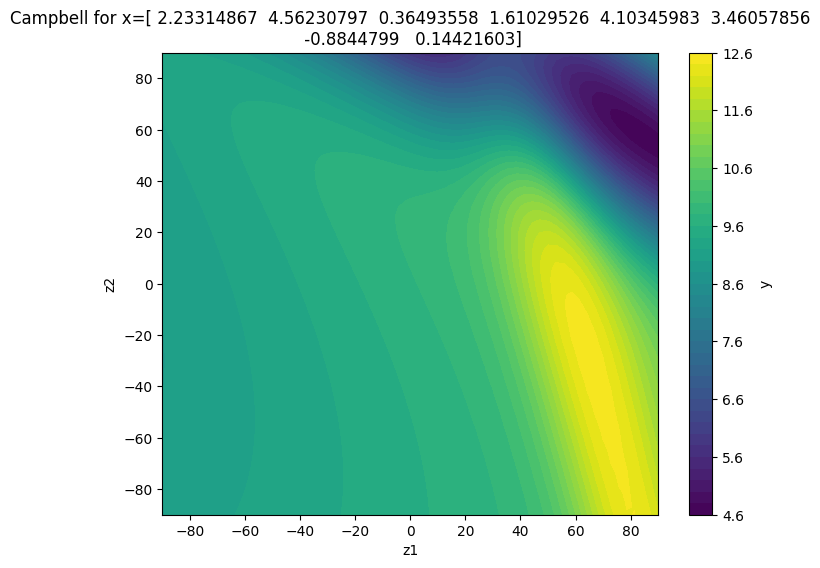

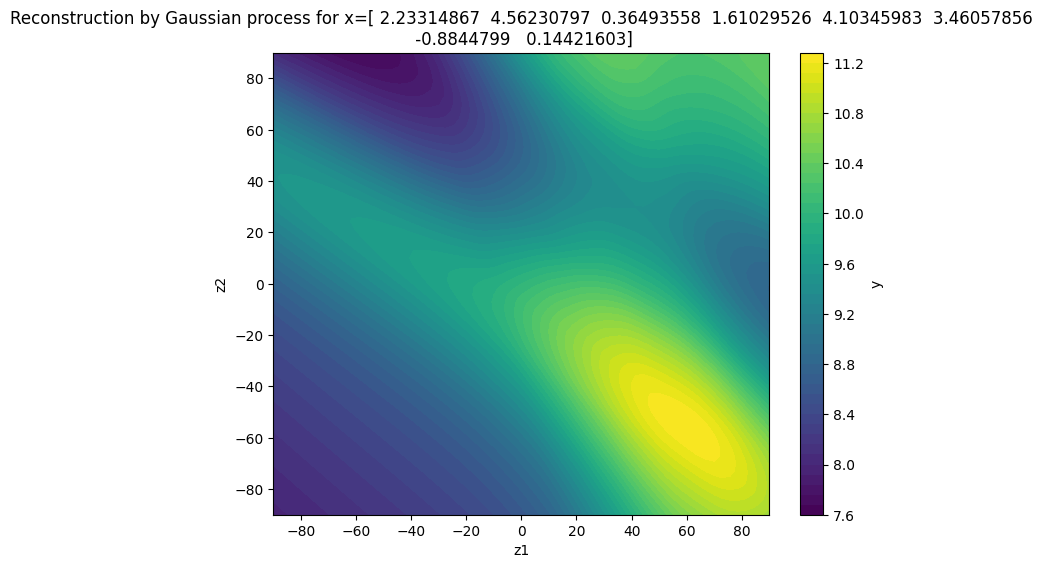

In [85]:
z1_vals=np.linspace(-90,90,n_grid)
z2_vals=np.linspace(-90,90,n_grid)

Z1,Z2=np.meshgrid(z1_vals,z2_vals)

#Vérité
plt.figure(figsize=(8, 6))
contour = plt.contourf(Z1, Z2, np.reshape(y_test[10,:],(n_grid,n_grid)), levels=50)
plt.colorbar(contour, label='y')
plt.xlabel('z1')
plt.ylabel('z2')
plt.title(f'Campbell for x={x_test[10,:]}')
plt.show()

#Prédiction
plt.figure(figsize=(8, 6))
contour = plt.contourf(Z1, Z2, np.reshape(Y_test_reconstruct[10,:],(n_grid,n_grid)), levels=50)
plt.colorbar(contour, label='y')
plt.xlabel('z1')
plt.ylabel('z2')
plt.title(f'Reconstruction by Gaussian process for x={x_test[10,:]}')
plt.show()

On a des résultats intéressants, on obtient des valeurs dans des intervalles similaires (pas de valeurs abérrantes). Maintenant, il faut vérifier toutes les formules pour être sûr qu'on obtient les bonnes valeurs de la méthode. 
Après normalement, la PCA seule donne les moins bons résultats. Il faut qu'on implémente la métrique RMSE et les 2 autres méthodes (ACPF avec ondelettes et B-splines) pour pouvoir comparer. 
Une fois qu'on aura les trois méthodes, on pourra ajouter une optimisation des hyper-paramètres: nombre de composantes de l'ACP et nombre de coeffs pour les décompositions Ondelettes et B-spline.

## ACPF avec base d'ondelette

In [86]:
n_pc = 5 #nombre composantes principales
K_tilde = 1200
p = 0.98
Y_test_reconstruct_wavelet = methods.ACPF_Ondelettes(x_train,x_test,y_train,n_pc,param,K_tilde=0,p=p)

Nombre de coefficients conservés pour l'ACP : 1953
(200, 5)
Variance expliquée par les 5 premières composantes : [0.78525304 0.1290855  0.03022842 0.01961651 0.01576949]
Variance globale expliquée : 0.9799529612283839
Taille du jeu d'entrainement transformé par ACP : (200, 5)


c:\Users\sliss\anaconda3\envs\PIR\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Affichage du résultat en 2D

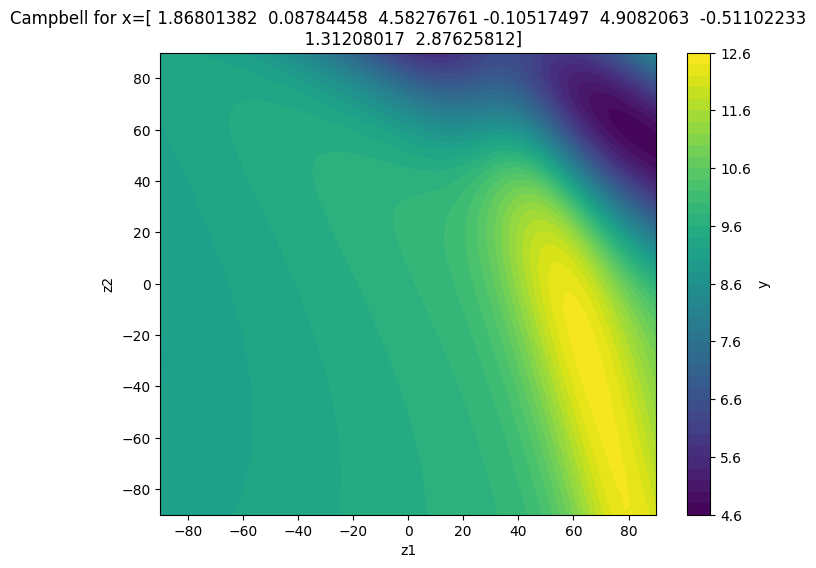

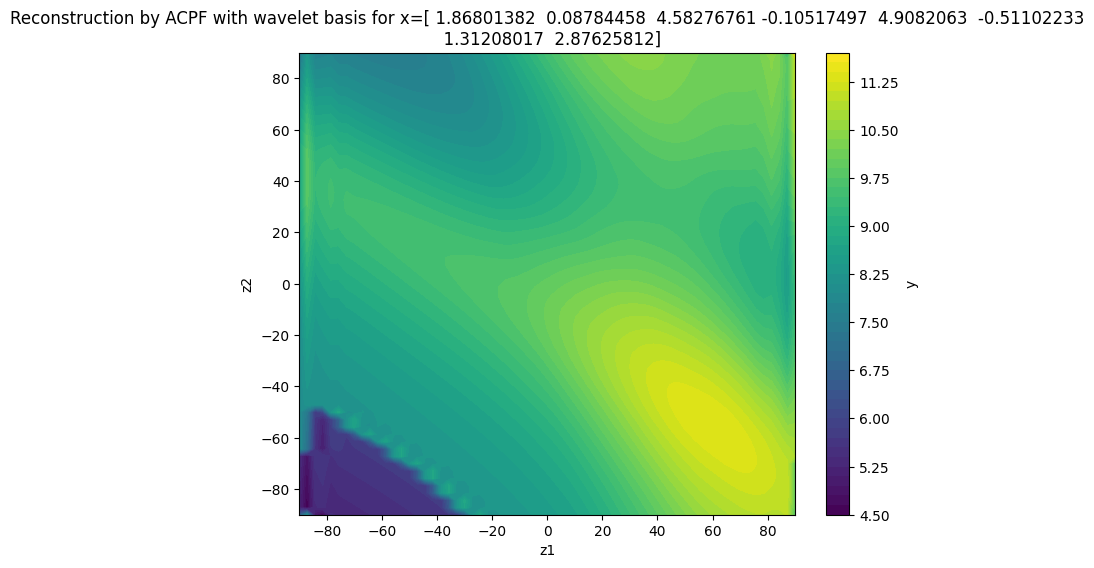

In [87]:
#Vérité
plt.figure(figsize=(8, 6))
contour = plt.contourf(Z1, Z2, np.reshape(y_test[10,:],(n_grid,n_grid)), levels=50)
plt.colorbar(contour, label='y')
plt.xlabel('z1')
plt.ylabel('z2')
plt.title(f'Campbell for x={x_test[5,:]}')
plt.show()

#Prédiction
plt.figure(figsize=(8, 6))
contour = plt.contourf(Z1, Z2, np.reshape(Y_test_reconstruct_wavelet[10,:],(n_grid,n_grid)), levels=50)
plt.colorbar(contour, label='y')
plt.xlabel('z1')
plt.ylabel('z2')
plt.title(f'Reconstruction by ACPF with wavelet basis for x={x_test[5,:]}')
plt.show()

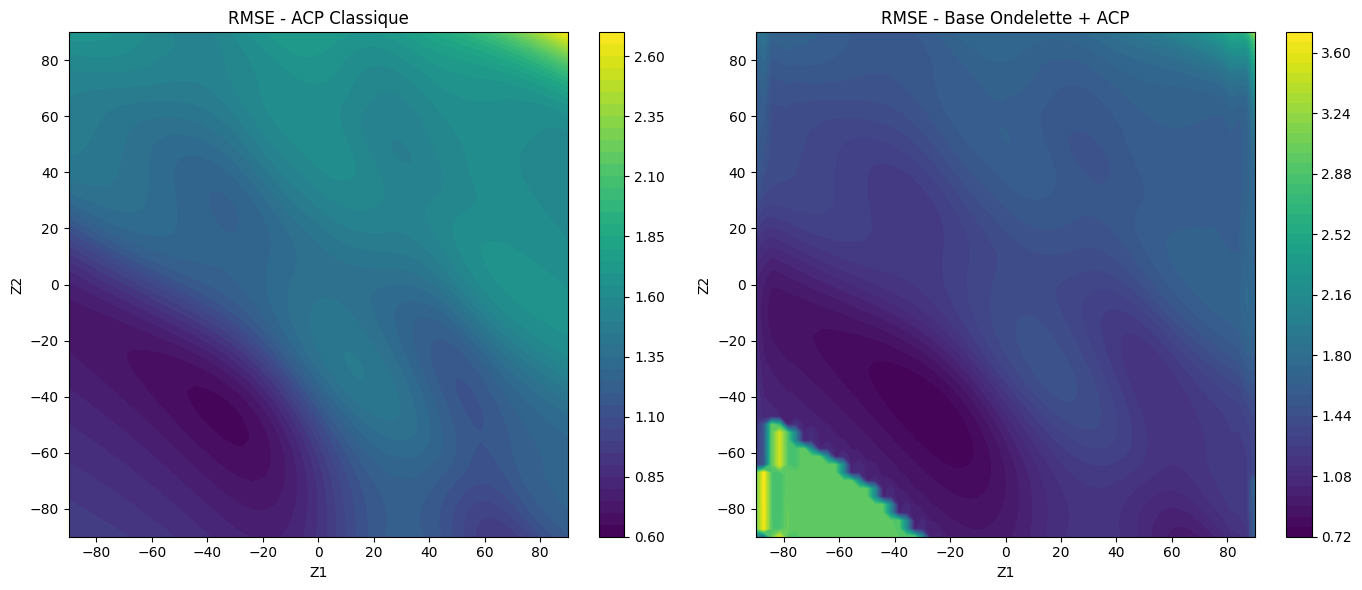

In [88]:
# --- Calcul RMSE pixel-par-pixel (classique)
rmse_ACP = np.sqrt(np.mean((y_test - Y_test_reconstruct)**2, axis=0))
RMSE_map_ACP = rmse_ACP.reshape((n_grid, n_grid))

# --- Calcul RMSE pixel-par-pixel (B-splines)
rmse_wavelet = np.sqrt(np.mean((y_test - Y_test_reconstruct_wavelet)**2, axis=0))
RMSE_map_wavelet = rmse_wavelet.reshape((n_grid, n_grid))

# --- Plot côte à côte
plt.figure(figsize=(14, 6))

# ACP classique
plt.subplot(1, 2, 1)
contour1 = plt.contourf(Z1, Z2, RMSE_map_ACP, levels=50)
plt.colorbar(contour1)
plt.title("RMSE - ACP Classique")
plt.xlabel("Z1")
plt.ylabel("Z2")

# ACP + B-splines
plt.subplot(1, 2, 2)
contour2 = plt.contourf(Z1, Z2, RMSE_map_wavelet, levels=50)
plt.colorbar(contour2)
plt.title("RMSE - Base Ondelette + ACP")
plt.xlabel("Z1")
plt.ylabel("Z2")

plt.tight_layout()
plt.show()